In [5]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import torch.nn.functional as F
from torch import nn
import itertools
from torch.utils.tensorboard import SummaryWriter
import random
import gc
from cebra_utils import *
from vit_pytorch import ViT
import pandas as pd

data_path = '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/processed/GRL3_2023-07-13_1'

In [6]:
## Given the path to a tif file, return that as a 3d numpy array
# @param path: path to tif file
# @return: 3d numpy array, first array is time dimension
def load_tif(path):
    img = cv2.imreadmulti(path, flags=(cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH))[1]
    img = np.array(img)
    return img

## Loads the brain data from a given trial
def load_brain_data(parent_directory, trial_num, type='gcamp'):
    # Load the data
    data_path = os.path.join(parent_directory, 'trial_' + str(trial_num) + '/brain/' + type + '.tif')
    data = load_tif(data_path)
    return data

def load_pose_data(parent_directory, trial_num):
    # Load the data
    data_path = os.path.join(parent_directory, 'trial_' + str(trial_num) + '/anipose/videos/pose-3d/vid.csv')
    data = pd.read_csv(data_path)
    data = data.to_numpy()
    return data

## Go through all trials and load the brain data for each trial
def load_all_brain_data_trials(parent_directory, type='gcamp'):
    # Get the number of trials
    num_trials = len([x for x in os.listdir(parent_directory) if 'trial_' in x])
    # Load the data
    return np.array([load_brain_data(parent_directory, trial_num, type) for trial_num in range(num_trials)])
    
## Takes a numpy array in and returns a memory mapped numpy array
# @param arr: numpy array to be memory mapped
# @param path: path to save the memory mapped array to
# @return: memory mapped numpy array
def memmap(arr, path):
    # Save the array
    np.save(path, arr)
    # Load the array
    return np.load(path, mmap_mode='r')

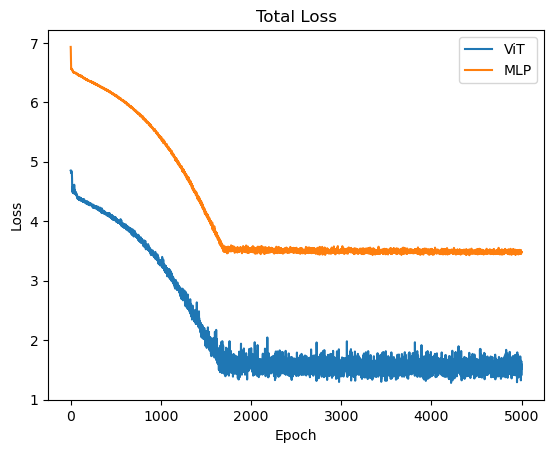

In [7]:
# append parent directory to sys path
sys.path.append('..')
ViT_CEBRA = torch.load('../Models/ViTModel_offset1_embedding2.pth')
CNN_CEBRA = torch.load('../Models/modelCNN.pth')
MLP_CEBRA = torch.load('../Models/MLPModel_offset1_embedding2.pth')
# plot all their losses
plt.plot(ViT_CEBRA.log['total'])
#plt.plot(CNN_CEBRA.log['total'])
plt.plot(MLP_CEBRA.log['total'])
plt.legend(['ViT', 'MLP'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.show()

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('ViT Parameters:', count_parameters(ViT_CEBRA))
print('CNN Parameters:', count_parameters(CNN_CEBRA))
print('MLP Parameters:', count_parameters(MLP_CEBRA))

ViT Parameters: 765625
CNN Parameters: 10969
MLP Parameters: 591497


In [9]:
# Load data from different session
data_path = '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/processed/FRM1_2023-07-07_1'
trial_count = len([x for x in os.listdir(data_path) if 'trial_' in x])
brain_data = [load_brain_data(data_path, x) for x in range(trial_count)]
flattened_brain_data = np.concatenate(brain_data, axis=0)
flattened_brain_data = np.array([cv2.resize(x, (64, 64)) for x in flattened_brain_data])
tensor_data = torch.from_numpy(flattened_brain_data).float()
eval_model = ViT_CEBRA.model.eval()
tensor_data = tensor_data.unsqueeze(2)
print(tensor_data.shape)
embedding_vit = []
num_frames = int(len(flattened_brain_data) / 3) 
for i in range(num_frames):
    embedding_vit.extend(eval_model(tensor_data[i*3: (i+1) * 3].to('cuda')).detach().cpu().numpy())

torch.Size([41472, 64, 1, 64])


In [10]:
One_D_brain_data =  [x.flatten() for x in flattened_brain_data]
One_D_brain_data = np.array(One_D_brain_data)
tensor_one_d = torch.from_numpy(One_D_brain_data).float()
eval_model_mlp = MLP_CEBRA.model.eval()
embedding_mlp = []
embedding_mlp = eval_model_mlp(tensor_one_d[:len(embedding_vit)].to('cuda')).detach().cpu().numpy()

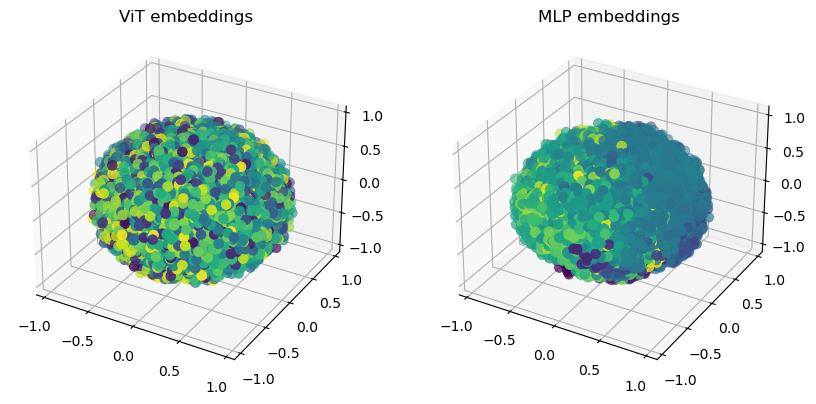

In [25]:
embedding_vit = np.array(embedding_vit)
# make a 3d scatter plot of the first 3 dimensions of the embedding
fig = plt.figure( figsize=(10,10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(embedding_vit[:,0], embedding_vit[:,1], embedding_vit[:,2], cmap='viridis', linewidth=0.5, c=(np.arange(len(embedding_vit)) % 288), s=50)
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(embedding_mlp[:,0], embedding_mlp[:,1], embedding_mlp[:,2], cmap='viridis', linewidth=0.5, c=(np.arange(len(embedding_mlp)) % 288), s=50)
# Label plots, left is ViT, right is MLP
ax.set_title('ViT embeddings')
ax2.set_title('MLP embeddings')
plt.show()

In [26]:
## Reshape embedding vectors from N * 288 x 8  to N x 288 x 8
def reshape_embedding(embedding):
    return np.reshape(embedding, (int(len(embedding) / 288), 288, 8))

batch_vit = reshape_embedding(embedding_vit)
batch_mlp = reshape_embedding(embedding_mlp)

In [27]:
## Load success Failure data from csv 
outcome_path = '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/outcomes/FRM1_2023-07-07_1.csv'
outcome_data = pd.read_csv(outcome_path)

## if outcome contains 's' append one to success array  else append 0 to success array
outcomes = outcome_data['Outcome']
# repkace all nan with None
outcomes = [x if x is not np.nan else None for x in outcomes]
success = []
for outcome in outcomes:
    if outcome is not None:
        outcome_split = outcome[1:-1].split(',')
        if 'ws' in outcome_split:
            success.append([1, 0])
        else:
            success.append([0, 1])
    else:
        success.append([0, 1])

In [28]:
## Load a simple LSTM model which takes in an embedding vector (288 x 8) and classifies it as success or failure
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, batch_size, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        self.hidden = self.init_hidden()
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to('cuda'),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to('cuda'))
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        out = self.fc(lstm_out[:, -1, :])
        return out
    def reset_weights(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
            
    
vit_classifier = LSTM(8, 64, 2, 1)
mlp_classifier = LSTM(8, 64, 2, 1)
vit_classifier = vit_classifier.to('cuda')
mlp_classifier = mlp_classifier.to('cuda')

In [29]:
## Evaluates the accuracy of a Model given a batch of data and labels
# @param model: model to evaluate
# @param batch: batch of data to evaluate
# @param labels: labels for the batch of data
# @return predictions: predictions for the batch of data and the accuracy of the model
def evaluate_model(model, batch, labels):
    model.eval()
    predictions = []
    correct = 0
    for i in range(len(batch)):
        model.hidden = model.init_hidden()
        prediction = (model(torch.from_numpy(batch[i]).float().unsqueeze(0).to('cuda')).detach().cpu().numpy())
        # argmax to get the prediction
        predictions.append(np.argmax(prediction))
        if np.argmax(prediction) == np.argmax(labels[i]):
            correct += 1
    return correct / len(batch), predictions


In [39]:
# Training loop for LSTM using k-fold cross validation
num_epochs = 300
k_folds = 5
test_splits = [i/k_folds for i in range(k_folds)]
test_splits.append(1)
criterion = nn.CrossEntropyLoss()
lr = 1e-3
vit_log = []
vit_accuracy = []
mlp_log = []
mlp_accuracy = []

# Create an array of indices to split the data into train and test
length = len(batch_vit)
indices = np.arange(len(batch_vit))
# use same seed
np.random.seed(1101)
np.random.shuffle(indices)
# Split the data into train and test
for i in range(k_folds):

    test_indices = indices[int(test_splits[i] * length ):int(test_splits[i+1] * length )]
    train_indices = np.delete(indices, test_indices)
    test_batch_vit = batch_vit[test_indices]
    test_batch_mlp = batch_mlp[test_indices]
    test_success = np.array(success)[test_indices]
    ## Train vit classifier
    # reset weights
    vit_classifier = LSTM(8, 64, 2, 1).to('cuda')
    optimizer_vit = torch.optim.Adam(vit_classifier.parameters(), lr=lr)
    vit_classifier.train()

    for i in range(num_epochs):
        vit_classifier.train()
        avg_loss = 0
        optimizer_mlp.zero_grad()
        loss = torch.tensor(0).to('cuda').float()
        for j in train_indices:
            optimizer_vit.zero_grad()
            vit_classifier.hidden = vit_classifier.init_hidden()
            outputs = vit_classifier(torch.from_numpy(batch_vit[j]).float().unsqueeze(0).to('cuda'))
            loss += criterion(outputs, torch.tensor([success[j]]).to('cuda').float())
            avg_loss += loss.item()
        loss.backward()
        optimizer_vit.step()
        
        avg_loss = avg_loss / len(train_indices)
        vit_log.append(avg_loss)
        accuracy, predictions = evaluate_model(vit_classifier, test_batch_vit, test_success)
        vit_accuracy.append(accuracy)
        print('\rEpoch: ', i, 'Loss: ' , avg_loss, 'Validation Accuracy: ' + str(accuracy)[:5], end='')

    # Evaluate the model
    accuracy, predictions = evaluate_model(vit_classifier, test_batch_vit, test_success)
    print('\n Final ViT Accuracy: ', accuracy)

    # Train mlp classifier
    # reset weights
    mlp_classifier = LSTM(8, 64, 2, 1).to('cuda')
    optimizer_mlp = torch.optim.Adam(mlp_classifier.parameters(), lr=lr)
    mlp_classifier.train()
    for i in range(num_epochs):
        mlp_classifier.train()
        avg_loss = 0
        optimizer_mlp.zero_grad()
        loss = torch.tensor(0).to('cuda').float()
        for j in train_indices:
            mlp_classifier.hidden = mlp_classifier.init_hidden()
            outputs = mlp_classifier(torch.from_numpy(batch_mlp[j]).float().unsqueeze(0).to('cuda'))
            loss += criterion(outputs, torch.tensor([success[j]]).to('cuda').float())

            avg_loss += loss.item()
        
        loss.backward()
        optimizer_mlp.step()
        avg_loss = avg_loss / len(train_indices)
        mlp_log.append(avg_loss)
        accuracy, predictions = evaluate_model(mlp_classifier, test_batch_mlp, test_success)
        mlp_accuracy.append(accuracy)
        print('\rEpoch: ', i, 'Loss: ' , str(avg_loss), 'Validation Accuracy: ' + str(accuracy)[:5], end='')

    # Evaluate the model
    accuracy, predictions = evaluate_model(mlp_classifier, test_batch_mlp, test_success)
    print('\n Final MLP Accuracy: ', accuracy)

Epoch:  299 Loss:  33.29666648239925 Validation Accuracy: 0.7552
 Final ViT Accuracy:  0.75
Epoch:  299 Loss:  1.1589463587623523 Validation Accuracy: 1.044
 Final MLP Accuracy:  1.0
Epoch:  299 Loss:  23.09798460525015 Validation Accuracy: 0.72446
 Final ViT Accuracy:  0.7241379310344828
Epoch:  299 Loss:  14.239848461876745 Validation Accuracy: 0.931
 Final MLP Accuracy:  0.9310344827586207
Epoch:  299 Loss:  0.0361483149068511 Validation Accuracy: 1.000
 Final ViT Accuracy:  1.0
Epoch:  299 Loss:  1.7259442305080999 Validation Accuracy: 0.965
 Final MLP Accuracy:  0.9655172413793104
Epoch:  299 Loss:  10.072093187207761 Validation Accuracy: 0.931
 Final ViT Accuracy:  0.9310344827586207
Epoch:  299 Loss:  3.459674280234005 Validation Accuracy: 0.9655
 Final MLP Accuracy:  0.9655172413793104
Epoch:  299 Loss:  0.6044652163334515 Validation Accuracy: 0.965
 Final ViT Accuracy:  0.9655172413793104
Epoch:  299 Loss:  12.89986286137415 Validation Accuracy: 0.9311
 Final MLP Accuracy:  0.

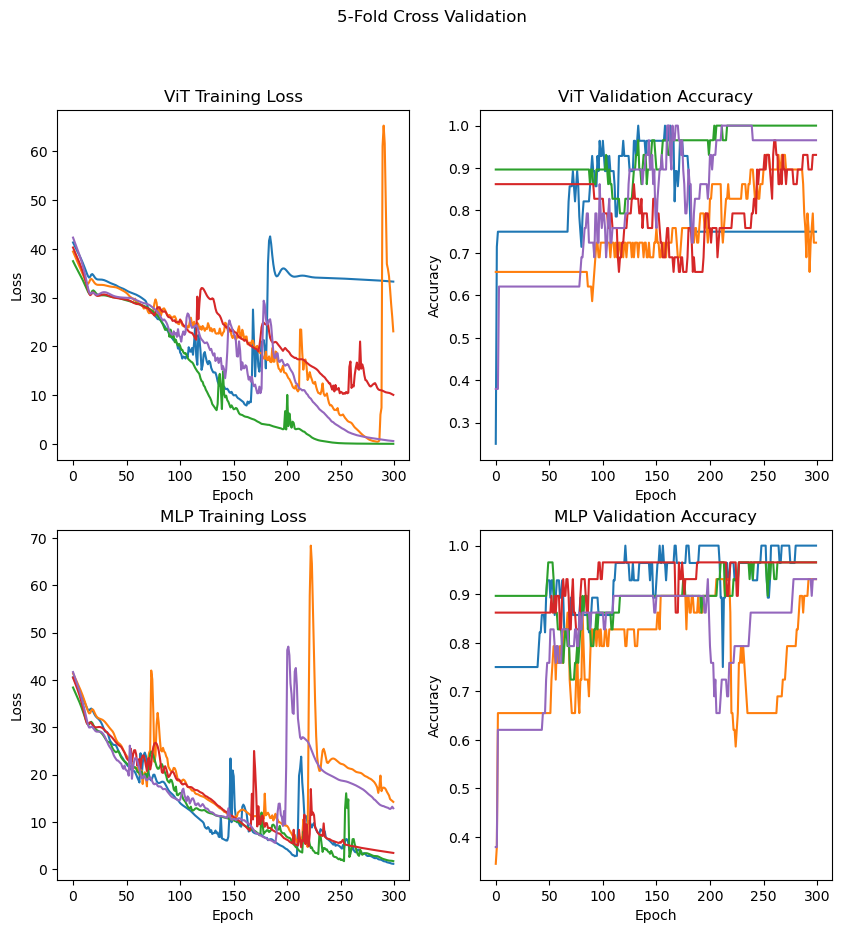

In [40]:
# plot both losses on the same graph
vit_log = np.array(vit_log).reshape(k_folds, num_epochs)
mlp_log = np.array(mlp_log).reshape(k_folds, num_epochs)
vit_accuracy = np.array(vit_accuracy).reshape(k_folds, num_epochs)
mlp_accuracy = np.array(mlp_accuracy).reshape(k_folds, num_epochs)
## Create two plots, one for each model
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# plot all the losses
for i in range(k_folds):
    axs[0, 0].plot(vit_log[i])
    axs[1, 0].plot(mlp_log[i])
    axs[0, 1].plot(vit_accuracy[i])
    axs[1, 1].plot(mlp_accuracy[i])

axs[0, 0].set_title('ViT Training Loss')
axs[1, 0].set_title('MLP Training Loss')
axs[0, 1].set_title('ViT Validation Accuracy')
axs[1, 1].set_title('MLP Validation Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[1, 0].set_xlabel('Epoch')
axs[0, 1].set_xlabel('Epoch')
axs[1, 1].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[1, 0].set_ylabel('Loss')
axs[0, 1].set_ylabel('Accuracy')
axs[1, 1].set_ylabel('Accuracy')
# Set figure title k-folds cross validation
fig.suptitle('5-Fold Cross Validation')
plt.show()

ViT Accuracy:  0.896551724137931
MLP Accuracy:  0.8275862068965517


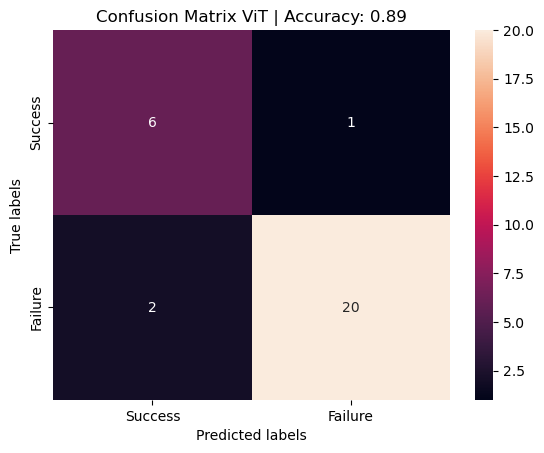

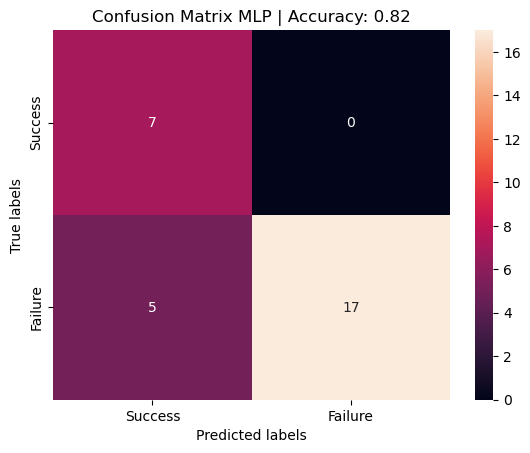

In [35]:

# Test the LSTM on last 20% of data
vit_classifier.eval()
mlp_classifier.eval()
vit_correct = 0
mlp_correct = 0
test_split = 0.8

# test set split
vit_test = batch_vit[int(len(batch_vit) * test_split):]
mlp_test = batch_mlp[int(len(batch_mlp) * test_split):]

# test set labels
vit_test_labels = success[int(len(batch_vit) * test_split):]
mlp_test_labels = success[int(len(batch_mlp) * test_split):]

# test set predictions
vit_predictions = []
mlp_predictions = []
for vit_embed in vit_test:
    vit_classifier.hidden = vit_classifier.init_hidden()
    prediction = (vit_classifier(torch.from_numpy(vit_embed).float().unsqueeze(0).to('cuda')).detach().cpu().numpy())
    # argmax to get the prediction
    vit_predictions.append(np.argmax(prediction))


for mlp_embed in mlp_test:
    mlp_classifier.hidden = mlp_classifier.init_hidden()
    prediction = (mlp_classifier(torch.from_numpy(mlp_embed).float().unsqueeze(0).to('cuda')).detach().cpu().numpy())
    # argmax to get the prediction
    mlp_predictions.append(np.argmax(prediction))

# calculate accuracy
vit_correct = 0
mlp_correct = 0
for i in range(len(vit_predictions)):
    if vit_predictions[i] == np.argmax(vit_test_labels[i]):
        vit_correct += 1
    if mlp_predictions[i] == np.argmax(mlp_test_labels[i]):
        mlp_correct += 1

print('ViT Accuracy: ', vit_correct / len(vit_predictions))
print('MLP Accuracy: ', mlp_correct / len(mlp_predictions))

# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plot confusion matrix for vit
cm = confusion_matrix(np.argmax(vit_test_labels, axis=1), vit_predictions)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix ViT | Accuracy: ' + str(vit_correct / len(vit_predictions))[:4])
ax.xaxis.set_ticklabels(['Success', 'Failure'])
ax.yaxis.set_ticklabels(['Success', 'Failure'])
plt.show()

# plot confusion matrix for mlp
cm = confusion_matrix(np.argmax(mlp_test_labels, axis=1), mlp_predictions)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix MLP | Accuracy: ' + str(mlp_correct / len(mlp_predictions))[:4])
ax.xaxis.set_ticklabels(['Success', 'Failure'])
ax.yaxis.set_ticklabels(['Success', 'Failure'])
plt.show()

In [19]:
from vit_pytorch.recorder import Recorder
ViT = [child2 for child2 in [child for child in eval_model.children()][0].children()][0]
ViT = Recorder(ViT)


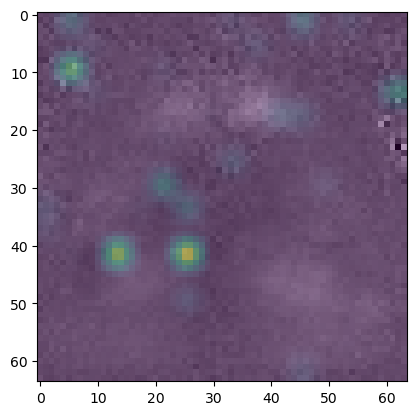

In [43]:
vid_index = 100
frame = 201
emb, attn = ViT(tensor_data.movedim(1,2)[288 * vid_index: (288 * (vid_index + 1))].to('cuda'))
brain_video =  tensor_data.squeeze()[288 * vid_index: (288 * (vid_index + 1))].detach().cpu().numpy()
attn_map = attn[frame].detach().cpu().numpy()
attn_map = np.sum(attn_map, axis=1)
last_layer = attn_map[-1]
head_index =48
head = last_layer[head_index, 1:]
grid_size = int(np.sqrt(attn_map.shape[-1]))
mapping = head.reshape(grid_size, grid_size)
plt.imshow(brain_video[frame], cmap='gray')
plt.imshow(cv2.resize(mapping, brain_video[0].shape), alpha=0.4)

In [21]:
## Input is attentions maps from ViT recorder
# shape is (depth ,num_heads, num_steps, num_steps)
def rollout(attn):
    # Take the mean across all heads (Subject to change)
    attn_mean = attn.mean(dim=1)

    # add identity adn normalize
    residual_attn = torch.eye(attn_mean.shape[-1]).unsqueeze(0).to('cpu') + attn_mean
    residual_attn = residual_attn / residual_attn.sum(dim=-1).unsqueeze(-1)
    # convert to numpy
    aug_attn_mat = residual_attn.detach().cpu().numpy()
    #Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, 1:].reshape(grid_size, grid_size)
    return mask

In [22]:
tensor_data.shape

torch.Size([41472, 64, 1, 64])

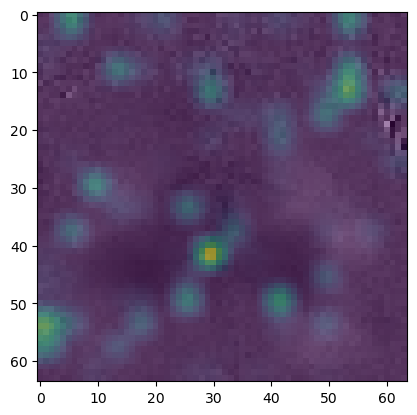

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
vid_index = 25
emb, attn = ViT(tensor_data.movedim(1,2)[(288 * vid_index): (288 * (vid_index + 1))].to('cuda'))
masks = [rollout(map.to('cpu')) for map in attn]
attention_video =  np.array([cv2.resize(mask, (64, 64)) for mask in masks])
brain_video =  tensor_data.squeeze()[288 * vid_index: (288 * (vid_index + 1))].detach().cpu().numpy()

frames = [] # for storing the generated images
fig = plt.figure()
for i in range(len(attention_video)):
    frames.append([plt.imshow(attention_video[i],animated=True), plt.imshow(brain_video[i], cmap='gray', alpha=0.5, animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('movie.mp4')
plt.show()